# Image Classification with CNN using Keras

# Task 1: Import Libraries

In [42]:
import tensorflow as tf
import os
import numpy as np

from matplotlib import pyplot as plt
%matplotlib inline

if not os.path.isdir('models'):
    os.mkdir('models')
    
print('TensorFlow version:', tf.__version__)
print('Is using GPU?', tf.test.is_gpu_available())

TensorFlow version: 2.3.0
Is using GPU? True


In [43]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

# Task 2: Preprocess Data

In [44]:
def get_three_classes(x, y):
    indices_0, _ = np.where(y == 0.)
    indices_1, _ = np.where(y == 1.)
    indices_2, _ = np.where(y == 2.)

    indices = np.concatenate([indices_0, indices_1, indices_2], axis=0)
    
    x = x[indices]
    y = y[indices]
    
    count = x.shape[0]
    indices = np.random.choice(range(count), count, replace=False)
    
    x = x[indices]
    y = y[indices]
    
    y = tf.keras.utils.to_categorical(y)
    
    return x, y

In [45]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()
x_train, y_train = get_three_classes(x_train, y_train)
x_test, y_test = get_three_classes(x_test, y_test)
print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

(15000, 32, 32, 3) (15000, 3)
(3000, 32, 32, 3) (3000, 3)


# Task 3: Visualize Examples

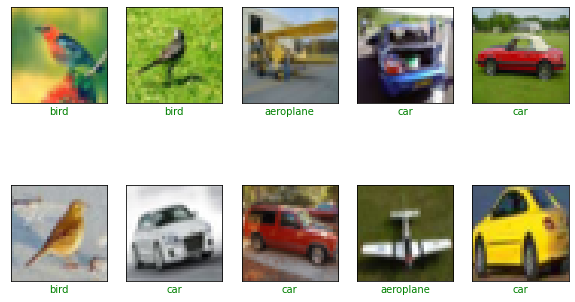

In [46]:
class_names = ['aeroplane', 'car', 'bird']

def show_random_examples(x, y, p):
    indices = np.random.choice(range(x.shape[0]), 10, replace=False)

    x = x[indices]
    y = y[indices]
    p = p[indices]

    plt.figure(figsize=(10,6))
    for i in range(10):
        plt.subplot(2, 5, i+1)
        plt.imshow(x[i])
        plt.xticks([])
        plt.yticks([])
        col = 'green' if np.argmax(y[i]) == np.argmax(p[i]) else 'red'
        plt.xlabel(class_names[np.argmax(p[i])], color=col)
    plt.show();

show_random_examples(x_train, y_train, y_train)    

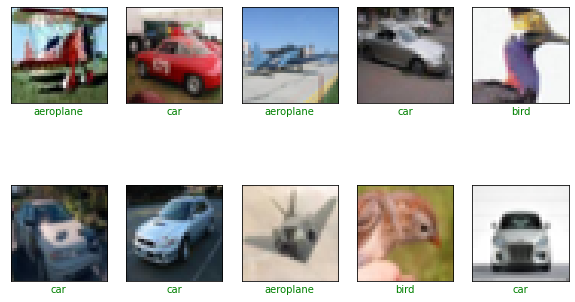

In [47]:
show_random_examples(x_test, y_test, y_test)  

# Task 4: Create Model

In [48]:
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from tensorflow.keras.layers import Dropout, Flatten, Input, Dense

def create_model():
    def add_conv_block(model, num_filters):
        model.add(Conv2D(num_filters, 3, activation='relu', padding='same'))
        model.add(BatchNormalization())
        model.add(Conv2D(num_filters, 3, activation='relu'))
        model.add(MaxPooling2D(pool_size=2))
        model.add(Dropout(0.5))
        return model
        
    model = tf.keras.models.Sequential()
    model.add(Input(shape=(32, 32, 3)))
    
    model = add_conv_block(model, 32)
    model = add_conv_block(model, 64)
    model = add_conv_block(model, 128)
    
    model.add(Flatten())
    model.add(Dense(3, activation='softmax'))

    model.compile(
        loss = 'categorical_crossentropy',
        optimizer='adam',
        metrics = ['accuracy']
    )
    return model

model = create_model()
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_18 (Conv2D)           (None, 32, 32, 32)        896       
_________________________________________________________________
batch_normalization_9 (Batch (None, 32, 32, 32)        128       
_________________________________________________________________
conv2d_19 (Conv2D)           (None, 30, 30, 32)        9248      
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 15, 15, 32)        0         
_________________________________________________________________
dropout_9 (Dropout)          (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_20 (Conv2D)           (None, 15, 15, 64)        18496     
_________________________________________________________________
batch_normalization_10 (Batc (None, 15, 15, 64)       


# Task 5: Train the Model

In [49]:
history = model.fit(
    x_train/255.,
    y_train,
    validation_data = (x_test/255., y_test),
    epochs=10,
    batch_size=128,
    callbacks = [
                 tf.keras.callbacks.EarlyStopping(monitor='val_accuracy',patience=3),
                 tf.keras.callbacks.ModelCheckpoint(
                     './models/model_{val_accuracy:.3f}.h5',
                     save_best_only=True,
                     save_weights_only=False,
                     monitor='val_accuracy'
                )
    ]
)

Epoch 1/10
118/118 [==============================] - 2s 15ms/step - loss: 0.8695 - accuracy: 0.6859 - val_loss: 1.6616 - val_accuracy: 0.3680
Epoch 2/10
118/118 [==============================] - 2s 13ms/step - loss: 0.5607 - accuracy: 0.7780 - val_loss: 1.4547 - val_accuracy: 0.4850
Epoch 3/10
118/118 [==============================] - 2s 13ms/step - loss: 0.4953 - accuracy: 0.8030 - val_loss: 1.5425 - val_accuracy: 0.5470
Epoch 4/10
118/118 [==============================] - 2s 14ms/step - loss: 0.4463 - accuracy: 0.8231 - val_loss: 0.6463 - val_accuracy: 0.7217
Epoch 5/10
118/118 [==============================] - 2s 13ms/step - loss: 0.4101 - accuracy: 0.8395 - val_loss: 0.3619 - val_accuracy: 0.8613
Epoch 6/10
118/118 [==============================] - 2s 13ms/step - loss: 0.3833 - accuracy: 0.8520 - val_loss: 0.3648 - val_accuracy: 0.8637
Epoch 7/10
118/118 [==============================] - 2s 13ms/step - loss: 0.3672 - accuracy: 0.8551 - val_loss: 0.3475 - val_accuracy: 0.8767

# Task 6: Final Predictions

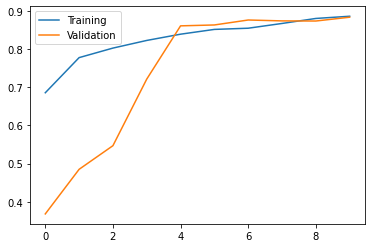

In [50]:
accs = history.history['accuracy']
val_accs = history.history['val_accuracy']

plt.plot(range(len(accs)), accs, label='Training')
plt.plot(range(len(accs)),val_accs, label='Validation')
plt.legend()
plt.show();

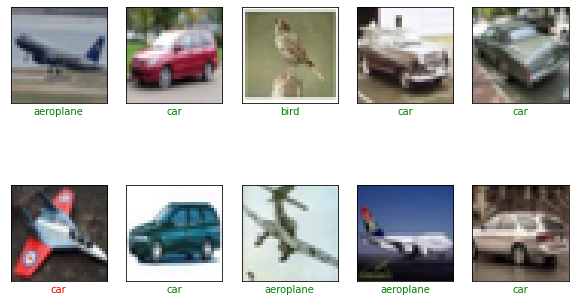

In [55]:
preds = model.predict(x_test/255.)
show_random_examples(x_test, y_test, preds)